In [21]:
root_path = "/Users/danieldubovski/projects/deep_query_optimization"

import sys
sys.path.insert(0, root_path)

In [22]:
import matplotlib as mpl
plt_backend = mpl.get_backend()
print(plt_backend)
from matplotlib import pyplot as plt
import pandas as pd
from pandas import Panel
import numpy as np
import pytorch_lightning as pl
import torch
from importlib import reload 
from tqdm.auto import tqdm

import sklearn
import seaborn as sns
import sklearn.metrics

from dqo.estimator.greq.regressor_v2.data_module import QueriesDataModule
from dqo.estimator.greq.regressor_v2.model import GREQRegressor
from dqo.datasets import QueriesDataset

mpl.use(plt_backend)

module://ipykernel.pylab.backend_inline


/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  


In [23]:
import os
print(os.getcwd())
checkpoint_path = os.path.join(os.getcwd(), 'logs/default/version_14/checkpoints/epoch=236.ckpt')
checkpoint_path

/Users/danieldubovski/projects/deep_query_optimization/dqo/estimator/greq/regressor_v2


'/Users/danieldubovski/projects/deep_query_optimization/dqo/estimator/greq/regressor_v2/logs/default/version_14/checkpoints/epoch=236.ckpt'

In [24]:
dm = QueriesDataModule(['imdb:resp_time_clean', 'tpch:exec_time_clean'])
dm.prepare_data()
dm.setup()

2020-09-16 21:19:32,728 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/resp_time_clean/runtimes/clean_part_00.csv [1/1]
2020-09-16 21:19:33,336 | dqo.datasets | INFO | Loaded 32148 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/resp_time_clean/runtimes/clean_part_00.csv [1/1]
2020-09-16 21:19:33,859 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpch/execution/exec_time_clean/runtimes/clean_01.csv [1/1]
2020-09-16 21:19:34,704 | dqo.datasets | INFO | Loaded 34757 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpch/execution/exec_time_clean/runtimes/clean_01.csv [1/1]


In [25]:
len(dm.ds.df[dm.ds.df.runtime > 500])

22

In [7]:
runtimes = np.array(runtimes)

In [11]:
import scipy.stats
scipy.stats.describe(runtimes)

DescribeResult(nobs=93444, minmax=(0.5001119738646997, 8.717346266022936), mean=4.2064152952602765, variance=5.077606865821641, skewness=0.30748704238185215, kurtosis=-0.9687195258570513)

In [246]:
def load_pretrained_model(checkpoint_path):
    torch.manual_seed(0)
    model = GREQRegressor()
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict'])
    model.eval()
    
    return model

In [247]:
from dqo.estimator.greq import gerelt_encoder as encoder
class QueryEstimater:
    def __init__(self, db_schema, model_checkpoint):
        self.db_schema = db_schema
        self.model = load_pretrained_model(model_checkpoint)
        
    def predict_query(self, q):
        x = encoder.encode_query(self.db_schema, q)
        return self.predict_encoded(x)
    
    def predict_encoded(self, x):
        with torch.no_grad():
            return 2 ** self.model(x).item()
    
    def predict_batch(self, batch, encoded=False, total=None, lowest=None):
        preds = []
        with torch.no_grad():
            for x in tqdm(batch, total=total or len(batch)):
                pred = self.predict_encoded(x) if encoded else self.predict_query(x)
                preds.append(max(pred, lowest) if lowest is not None else pred)

        return preds

In [248]:
def plot_log2_confusion(predictions, actual):    
    predictions = np.array(predictions)
    actual = np.array(actual)

    predictions = np.round(np.log2(predictions)).astype(int)
    actual = np.round(np.log2(actual)).astype(int)
    
    labels = list(set(list(actual)) | set(list(predictions)))
    labels = [str(l) for l in sorted(labels)]
    
    conf = sklearn.metrics.confusion_matrix(predictions, actual)
    acc = sklearn.metrics.accuracy_score(predictions, actual)
    balanced_acc = sklearn.metrics.balanced_accuracy_score(predictions, actual, adjusted=True)
    f1_m = sklearn.metrics.f1_score(predictions, actual, average='macro')
    f1_w = sklearn.metrics.f1_score(predictions, actual, average='weighted')
    sns.heatmap(conf, fmt="g", annot=True, xticklabels=labels, yticklabels=labels)
    plt.title(f'accuracy: {acc} \n balanced_accuracy: {balanced_acc} \n mae: {np.mean(np.abs(actual - predictions))} \n f1 macro: {f1_m} \n f1 weighted: {f1_w}')
    plt.show()

In [249]:
imdb_queries = QueriesDataset('imdb:small_uniform')

In [250]:
imdb_df = imdb_queries.load()
imdb_schema = imdb_queries.schema()

2020-09-09 22:32:02,193 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/small_uniform/runtimes/clean_augmented_part_00.csv [1/1]
2020-09-09 22:32:03,080 | dqo.datasets | INFO | Loaded 87034 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/small_uniform/runtimes/clean_augmented_part_00.csv [1/1]


In [8]:
imdb_estimator = QueryEstimater(imdb_schema, checkpoint_path)

<AxesSubplot:>

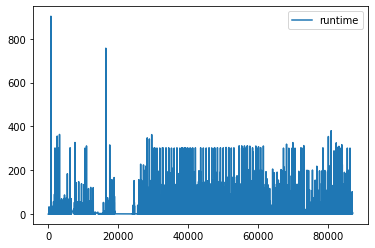

In [10]:
imdb_df.groupby('runtime').head(1).plot()

In [13]:
imdb_distinct = imdb_df.groupby('runtime').head(1)
y_true = list(imdb_distinct['runtime'])
y_pred = imdb_estimator.predict_batch(list(imdb_distinct['query']))

/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


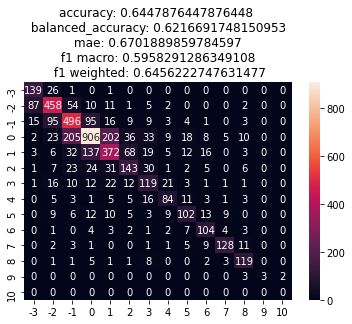

In [242]:
plot_log2_confusion(y_pred, y_true)

In [84]:
qdm = QueriesDataModule('imdb:small_uniform')
qdm.setup()

2020-09-05 16:11:55,932 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/small_uniform/runtimes/clean_augmented_part_00.csv [1/1]
2020-09-05 16:11:56,747 | dqo.datasets | INFO | Loaded 87034 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/small_uniform/runtimes/clean_augmented_part_00.csv [1/1]


In [86]:
test_true = []
test_pred = []
with torch.no_grad():
    for item in tqdm(qdm.test_dataloader()):
        test_true.append(2 ** item['runtime'])
        test_pred.append(imdb_estimator.predict_encoded(item['input']))

In [239]:
plot_log2_confusion(test_pred, test_true)

TypeError: accuracy_score() got an unexpected keyword argument 'adjusted'

In [17]:
imdb_estimator.predict_query('select MIN(id) from aka_title')

0.3487551234163082

In [60]:
imdb_estimator.predict_query('select MIN(id) from aka_title, cast_info where aka_title.movie_id = cast_info.movie_id and cast_info.note like "%a%"')

11.159208242646764

In [61]:
imdb_estimator.predict_query('select MIN(id) from aka_title, cast_info where aka_title.movie_id = cast_info.movie_id and aka_title.movie_id > 10')

26.097686612759194

In [62]:
imdb_estimator.predict_query('select MIN(id) from aka_title, cast_info where aka_title.movie_id = cast_info.movie_id')

98.77698618825976

In [63]:
imdb_estimator.predict_query('select MIN(id) from cast_info')

2.9044822055115933

## TPCH

In [301]:
tpch_ds = QueriesDataset('tpch:uniform2')

In [302]:
tpch_df = tpch_ds.load()
tpch_schema = tpch_ds.schema()

2020-09-10 20:46:53,224 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpch/execution/uniform2/runtimes/aug_1000_0:15555.csv [1/8]
2020-09-10 20:46:53,386 | dqo.datasets | INFO | Loaded 15555 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpch/execution/uniform2/runtimes/aug_1000_0:15555.csv [1/8]
2020-09-10 20:46:53,387 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpch/execution/uniform2/runtimes/aug_1000_1000:17056.csv [2/8]
2020-09-10 20:46:53,534 | dqo.datasets | INFO | Loaded 16056 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpch/execution/uniform2/runtimes/aug_1000_1000:17056.csv [2/8]
2020-09-10 20:46:53,535 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpch/execution/uniform2/runtimes/aug_1000_2000:16317.csv [3/8]
2020-09-10 

In [303]:
tpch_df = tpch_df.query('runtime < 500')

In [304]:
tpch_df['bucket'] = tpch_df['runtime'].apply(np.log2).apply(np.round).apply(lambda x: max(0, x)).astype(int)

In [305]:
tpch_df.groupby('bucket').count().mean()

query      13222.1
runtime    13222.1
dtype: float64

In [306]:
# tpch_df = tpch_df.groupby('bucket').head(1500)

In [307]:
from collections import Counter


In [308]:
tpch_estimaor = QueryEstimater(tpch_schema, checkpoint_path)

In [309]:
tpch_queries, tpch_labels = list(tpch_df['query']), list(tpch_df['runtime'].apply(lambda x: max(x, 1)))
label_counts = Counter(np.round(np.log2(tpch_labels)))
print(label_counts, len(label_counts))

Counter({0.0: 28249, 4.0: 24345, 2.0: 20254, 1.0: 18722, 3.0: 13394, 5.0: 11439, 6.0: 7687, 7.0: 7062, 8.0: 1066, 9.0: 3}) 10


In [310]:
tpch_predictions = tpch_estimaor.predict_batch(tpch_queries, lowest=1)

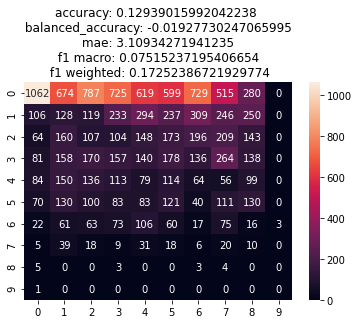

In [295]:
# Rows - prediction, Columns - actual
plot_log2_confusion(tpch_predictions, tpch_labels)

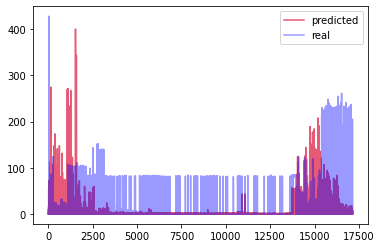

In [227]:
plt.plot(tpch_predictions, 'crimson', alpha=0.7)
plt.plot(tpch_labels,  'blue', alpha=0.4)
plt.legend(['predicted', 'real'])

<div> 1</div>